# Bathymetry

<https://emodnet.ec.europa.eu/en/bathymetry>

In [1]:
import os
from zipfile import BadZipFile, ZipFile
import matplotlib.pyplot as plt
import contextily as cx
from src import data as rd
import rioxarray as rxr
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio as rio
import seaborn as sns

In [2]:
# base data download directory
DATA_DIR = os.path.join("data", "bathymetry")

# DTM tile D4
FILE_NAME = "D4_2022.tif.zip"

URL = "https://downloads.emodnet-bathymetry.eu/v11/" + FILE_NAME

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [3]:
rd.download_data(url=URL, data_dir=DATA_DIR, file_name=FILE_NAME)

Data 'D4_2022.tif.zip' already exists in 'data/bathymetry'.
Data downloaded on: 2024-01-05 01:34:31.695837+00:00
Download URL: https://downloads.emodnet-bathymetry.eu/v11/D4_2022.tif.zip
SHA256 hash: 23e312b83101ef9d563ba4bab651fbab72dff62c51382eed72e27aa907584aec



In [4]:
ZipFile(DATA_FILE).namelist()

['D4_2022_mean.tif']

In [5]:
# extract the archive
try:
    z = ZipFile(DATA_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

In [3]:
data = rxr.open_rasterio(
    os.path.join(DATA_DIR, "D4_2022_mean.tif"), chunks="auto"
)

In [7]:
data

<xarray.DataArray (band: 1, y: 9004, x: 9484)>
dask.array<open_rasterio-a5e7978f4b9f2a1e2f282c3eb68994a3<this-array>, shape=(1, 9004, 9484), dtype=float32, chunksize=(1, 3538, 9484), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -6.377 -6.376 -6.374 -6.373 ... 3.499 3.501 3.502
  * y            (y) float64 61.88 61.88 61.87 61.87 ... 52.5 52.5 52.5 52.5
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  GGSgc GeoTIFF export
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0

In [8]:
data.rio.crs

CRS.from_epsg(4326)

In [9]:
data.rio.bounds()

(-6.377083333333333, 52.49791666666666, 3.5020833333333345, 61.87708333333333)

In [10]:
data.rio.resolution()

(0.0010416666666666667, -0.0010416666666666667)

In [4]:
# read Kish Basin data and extent
ds, extent = rd.read_dat_file(dat_path=os.path.join("data", "kish-basin"))

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

In [6]:
shape = rd.halite_shape(dat_xr=ds).buffer(1000).buffer(-1000)

In [7]:
data.rio.reproject(rd.CRS).rio.resolution()

(92.06463716186485, -92.06463716186485)

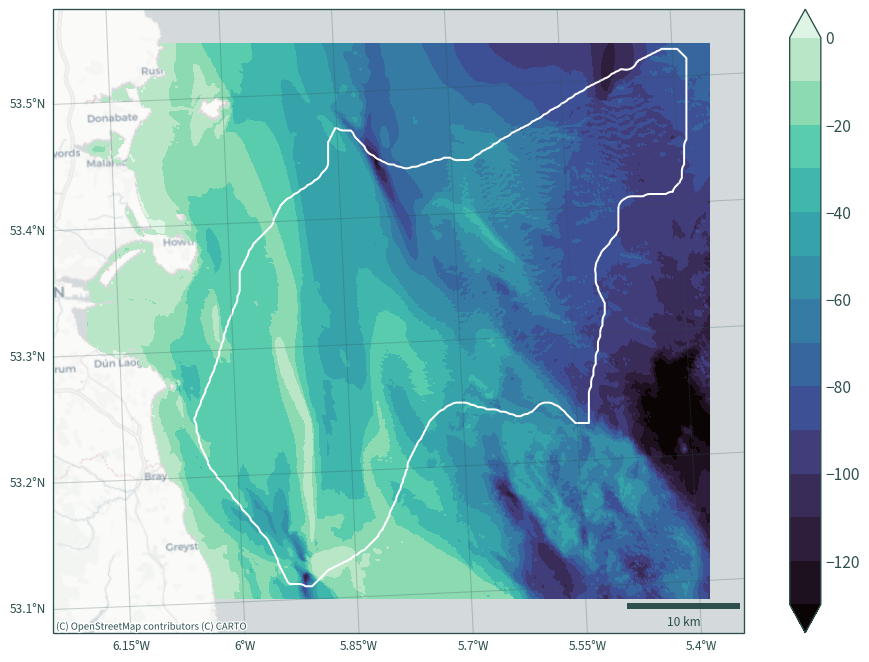

In [14]:
plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.epsg(rd.CRS))
data.rio.reproject(rd.CRS).rio.clip(extent).isel(band=0).plot.contourf(
    ax=ax, robust=True, cmap="mako", levels=15
)
shape.boundary.plot(ax=ax, color="white")

plt.ylim(ymin - 3000, ymax + 3000)
plt.xlim(xmin - 3000, xmax + 3000)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=rd.CRS, zoom=10)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=0.25, color="darkslategrey"
)
ax.add_artist(
    ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
)

plt.title(None)
plt.tight_layout()
plt.show()

## Reproject bathymetry to match the Kish Basin data

In [8]:
data_ = data.rio.reproject_match(ds, resampling=rio.enums.Resampling.bilinear)

In [16]:
data_

<xarray.DataArray (band: 1, y: 237, x: 218)>
array([[[-14.594848 , -15.727844 , -17.353876 , ..., -75.13085  ,
         -75.03473  , -75.388954 ],
        [-13.633065 , -14.9118805, -16.584257 , ..., -75.50923  ,
         -75.28749  , -75.942345 ],
        [-12.795093 , -14.0657625, -15.768589 , ..., -76.10867  ,
         -75.42323  , -75.87239  ],
        ...,
        [        nan,         nan,         nan, ..., -63.430305 ,
         -62.244442 , -60.888393 ],
        [        nan,         nan,         nan, ..., -61.364273 ,
         -61.213135 , -60.662186 ],
        [        nan,         nan,         nan, ..., -60.220272 ,
         -59.354317 , -60.166344 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  GGSgc GeoTIFF export
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                nan

In [17]:
data_.rio.crs

CRS.from_epsg(23029)

In [18]:
data_.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [19]:
data_.rio.resolution()

(200.0, -200.0)

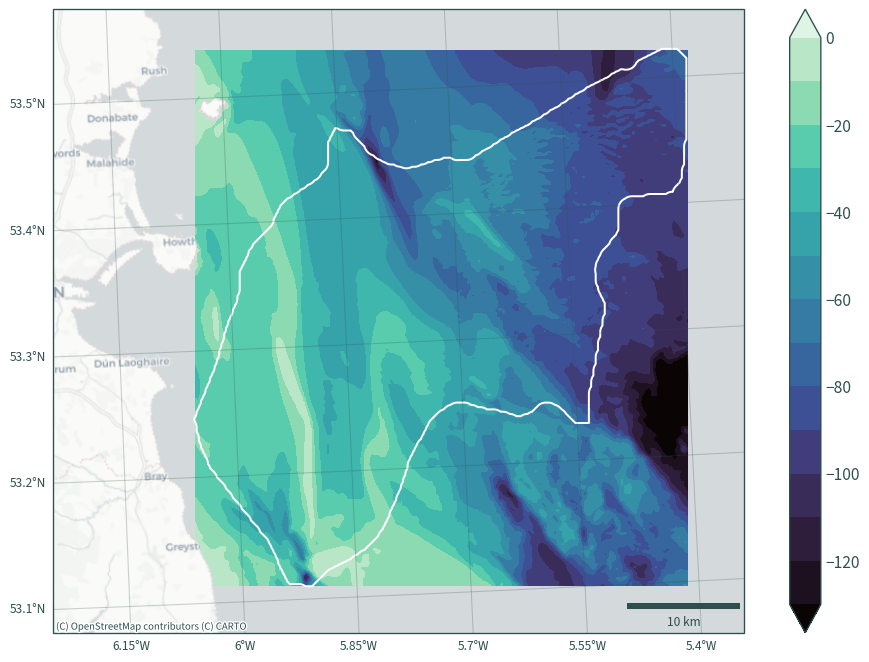

In [20]:
plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.epsg(rd.CRS))
data_.isel(band=0).plot.contourf(
    ax=ax, extend="both", cmap="mako", levels=14, vmax=0, vmin=-130
)
shape.boundary.plot(ax=ax, color="white")

plt.ylim(ymin - 3000, ymax + 3000)
plt.xlim(xmin - 3000, xmax + 3000)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=rd.CRS, zoom=10)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=0.25, color="darkslategrey"
)
ax.add_artist(
    ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
)

plt.title(None)
plt.tight_layout()
plt.show()

## Adjust Kish Basin depth from sea level to seabed

In [9]:
ds = ds.assign(TopDepthSeabed=ds["TopDepth"] + data_.isel(band=0))
ds = ds.assign(BaseDepthSeabed=ds["BaseDepth"] + data_.isel(band=0))

In [10]:
ds["TopDepthSeabed"].attrs = ds["TopDepth"].attrs
ds["BaseDepthSeabed"].attrs = ds["BaseDepth"].attrs

In [11]:
ds

<xarray.Dataset>
Dimensions:          (halite: 4, y: 237, x: 218)
Coordinates:
  * y                (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x                (x) float64 6.966e+05 6.968e+05 ... 7.398e+05 7.4e+05
    spatial_ref      int64 0
  * halite           (halite) <U8 'Fylde' 'Mythop' 'Preesall' 'Rossall'
    band             int64 1
Data variables:
    BaseDepth        (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    Thickness        (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    TopDepth         (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    TopTWT           (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    TopDepthSeabed   (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    BaseDepthSeabed  (halite, y, x) float64 nan nan nan nan ... nan nan nan nan

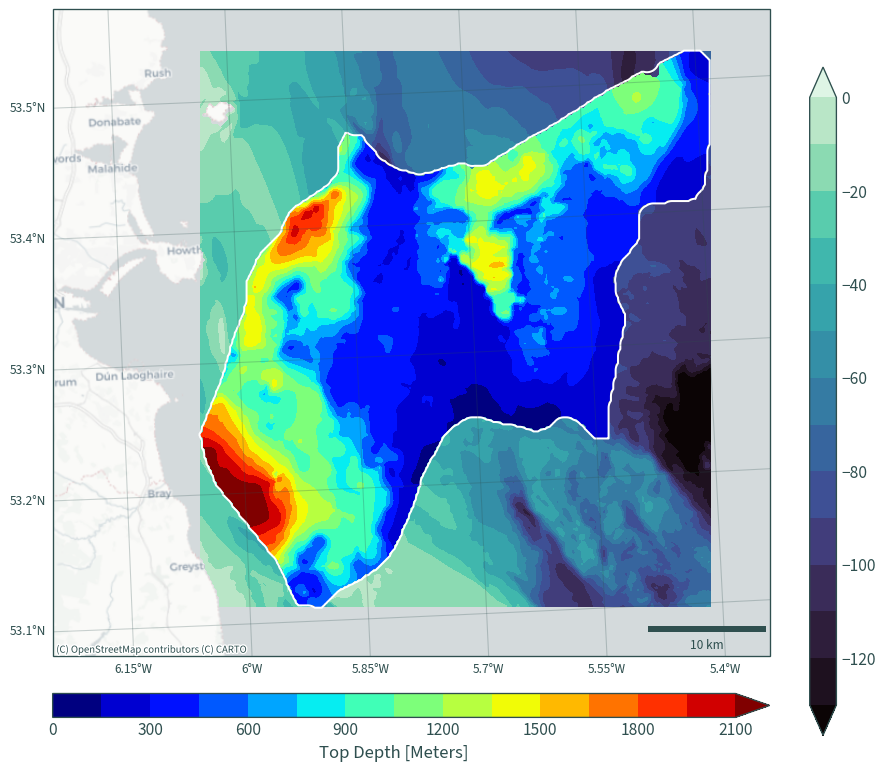

In [38]:
plt.figure(figsize=(10, 9))
ax = plt.axes(projection=ccrs.epsg(rd.CRS))
data_.isel(band=0).plot.contourf(
    ax=ax,
    extend="both",
    cmap="mako",
    levels=14,
    vmax=0,
    vmin=-130,
    cbar_kwargs={"pad": 0.045, "shrink": 0.8, "aspect": 25},
)
shape.boundary.plot(ax=ax, color="white")

ds["TopDepthSeabed"].sel(halite="Rossall").plot.contourf(
    cmap="jet",
    levels=15,
    robust=True,
    ax=ax,
    cbar_kwargs={"location": "bottom", "aspect": 30, "pad": 0.045},
)

plt.ylim(ymin - 3000, ymax + 3000)
plt.xlim(xmin - 3000, xmax + 3000)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=rd.CRS, zoom=10)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=0.25, color="darkslategrey"
)
ax.add_artist(
    ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
)

plt.title(None)
plt.tight_layout()
plt.show()

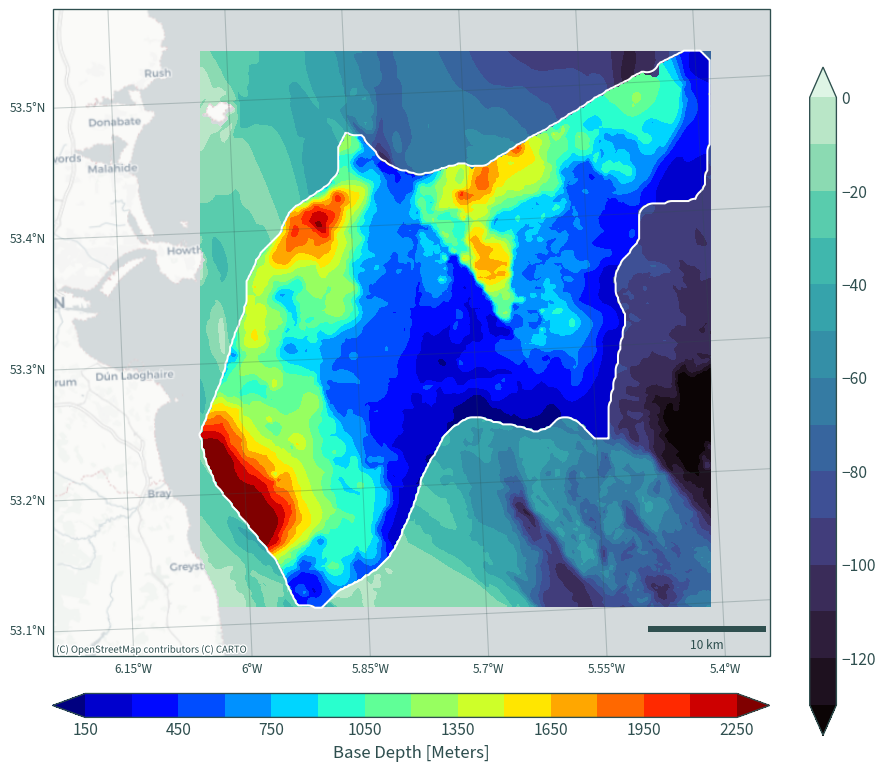

In [12]:
plt.figure(figsize=(10, 9))
ax = plt.axes(projection=ccrs.epsg(rd.CRS))
data_.isel(band=0).plot.contourf(
    ax=ax,
    extend="both",
    cmap="mako",
    levels=14,
    vmax=0,
    vmin=-130,
    cbar_kwargs={"pad": 0.045, "shrink": 0.8, "aspect": 25},
)
shape.boundary.plot(ax=ax, color="white")

ds["BaseDepthSeabed"].sel(halite="Rossall").plot.contourf(
    cmap="jet",
    levels=15,
    robust=True,
    ax=ax,
    cbar_kwargs={"location": "bottom", "aspect": 30, "pad": 0.045},
)

plt.ylim(ymin - 3000, ymax + 3000)
plt.xlim(xmin - 3000, xmax + 3000)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=rd.CRS, zoom=10)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=0.25, color="darkslategrey"
)
ax.add_artist(
    ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
)

plt.title(None)
plt.tight_layout()
plt.show()